In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

from Finite_volume_method_1D import *

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90

lambdanm = 402
KID402 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 673
KID673 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 986
KID986 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 1545
KID1545 = KID_data(chippath,lambdanm,filename,length)

In [3]:
KID402.fit_tail(start=150,end=250,showplots=False)
KID673.fit_tail(start=150,end=250,showplots=False)
KID986.fit_tail(start=150,end=250,showplots=False)
KID1545.fit_tail(start=130,end=230,showplots=False)

KIDdict = {
    402 : KID402,
    673 : KID673,
    986 : KID986,
    1545 : KID1545
}
print(KID1545.Quality)

9561.031179594


In [4]:
print(KID402.tauqpstar,KID402.tauqpstarstd)
print(KID673.tauqpstar,KID673.tauqpstarstd)
print(KID986.tauqpstar,KID986.tauqpstarstd)
print(KID1545.tauqpstar,KID1545.tauqpstarstd)
print(KID402.L)
print(KID673.L)
print(KID986.L)
print(KID1545.L)

L=np.mean([KID402.L,KID673.L,KID986.L,KID1545.L])

64.47248733519922 4.86899916554073
58.248553397863745 4.300854595584184
67.3438194726096 6.939516763746381
62.03713253438946 11.676947426565471
0.015510492015003163
0.017167808325977668
0.014849172616452574
0.016119378171543686


In [12]:
simtime = 10
leeway = 0

FITx = np.arange(simtime-leeway)*KID402.dt
FITy = {}
for l in [402,673,986,1545]:
    indmin = np.argmax(KIDdict[l].phase)
    indmax = indmin + simtime - leeway
    FITy[l] = KIDdict[l].phase[indmin:indmax]

plotdatay = np.array([FITy[402],FITy[673],FITy[986],FITy[1545]])
fitdatay = plotdatay.ravel()

def func_to_parallelize(t,K,phi_init,l,KID):
     SIM = KID_sim(KID,0.13,K,phi_init/l,0.01,1/5,sigma_IC=2,simtime_approx=simtime,D_const=False,adaptivedx=True)
     return np.interp(t,SIM.t_axis,SIM.timeseriestheta)

100%|██████████| 5000/5000 [00:02<00:00, 1901.58it/s]


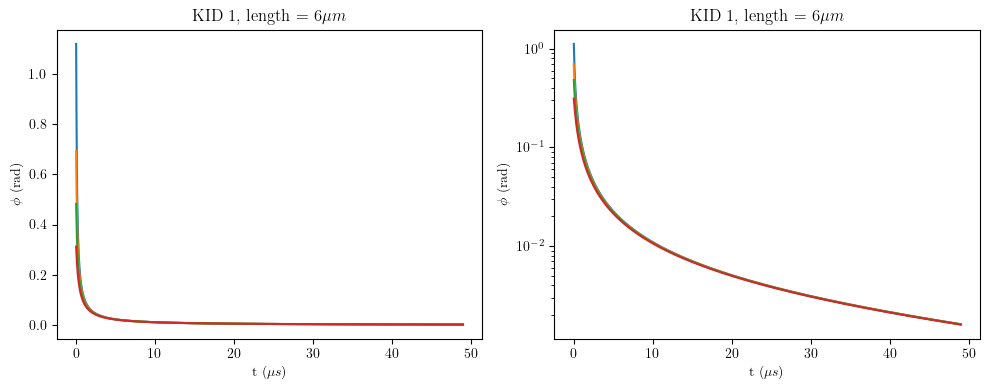

100%|██████████| 5000/5000 [00:03<00:00, 1664.78it/s]


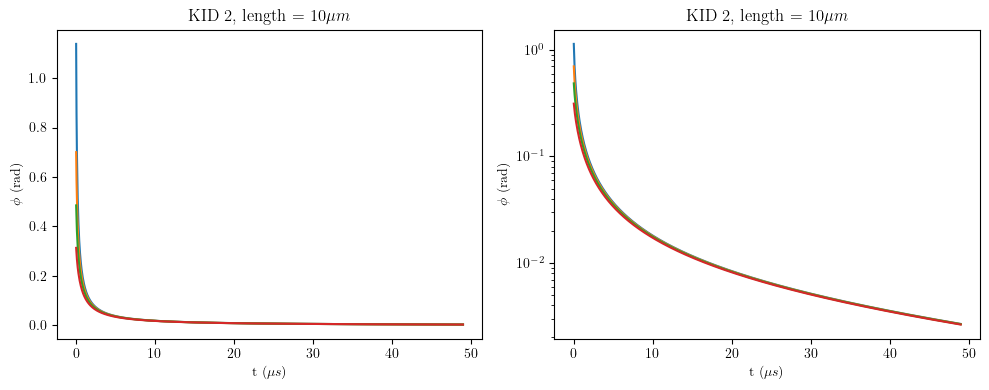

100%|██████████| 5000/5000 [00:06<00:00, 756.47it/s] 


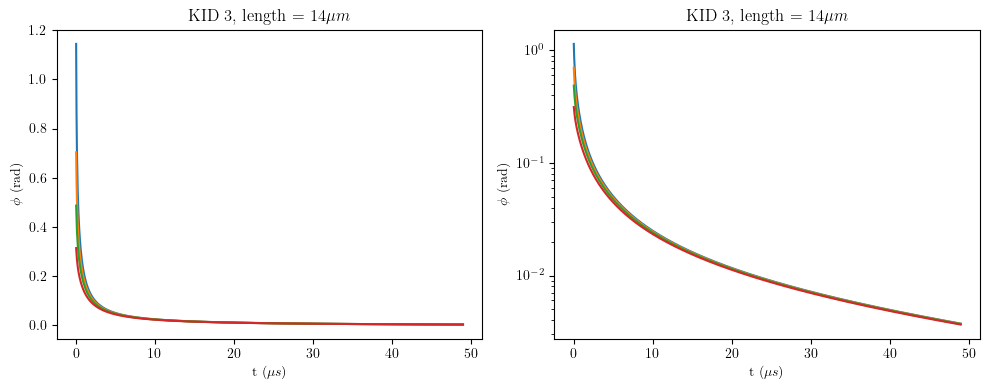

100%|██████████| 5000/5000 [00:06<00:00, 807.34it/s]


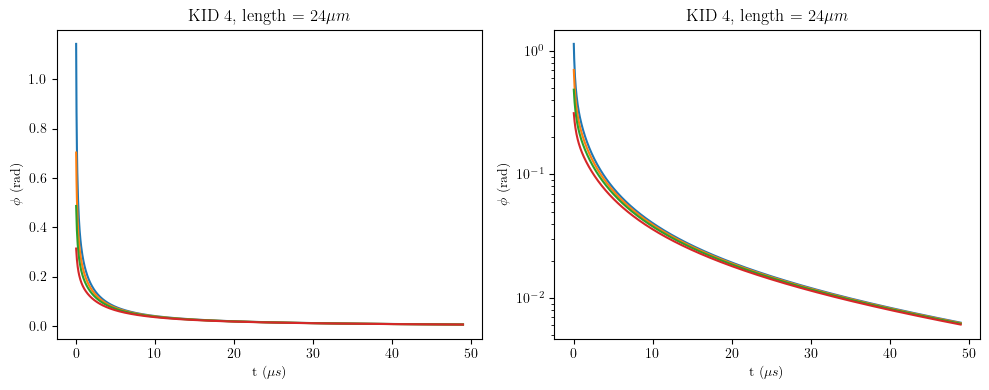

100%|██████████| 5000/5000 [00:07<00:00, 692.02it/s]


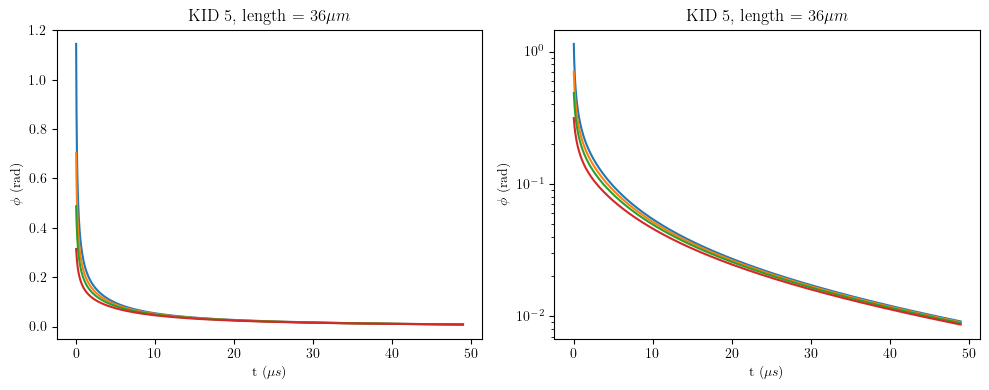

100%|██████████| 5000/5000 [00:10<00:00, 469.46it/s]


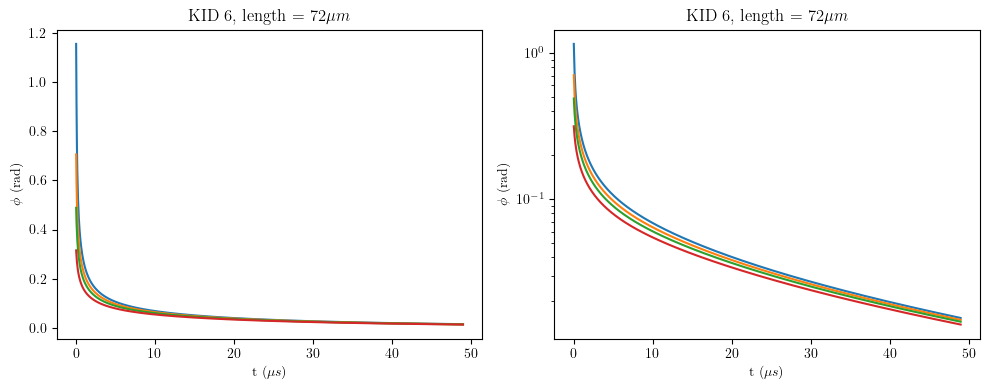

100%|██████████| 5000/5000 [02:17<00:00, 36.49it/s] 


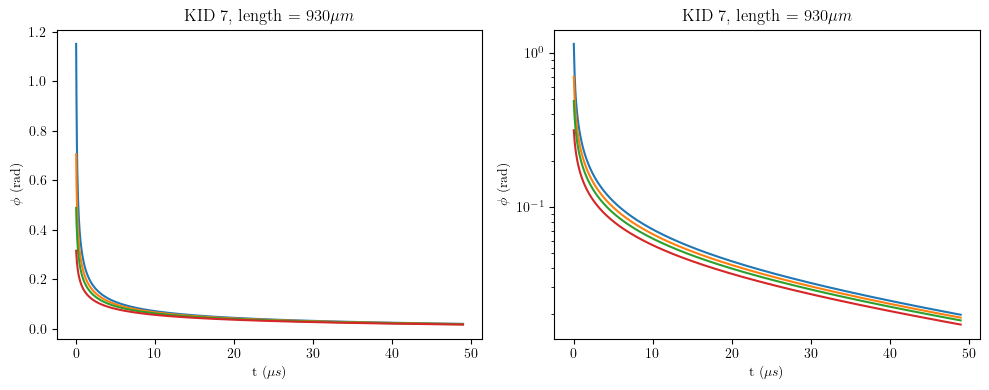

100%|██████████| 5000/5000 [00:04<00:00, 1122.47it/s]


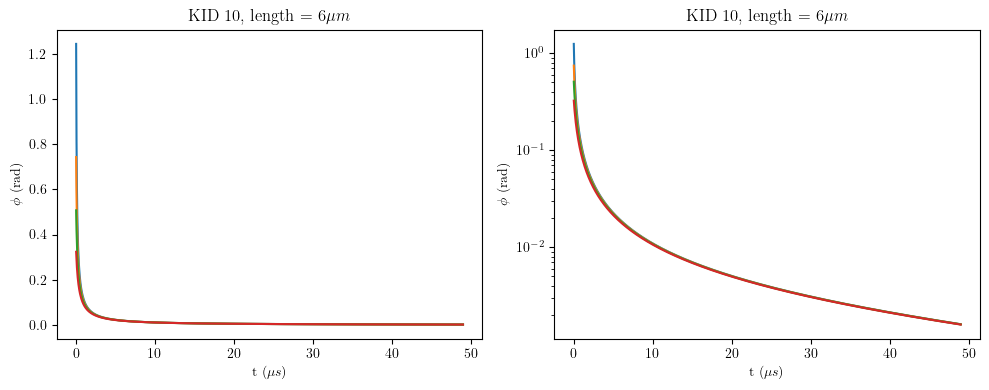

100%|██████████| 5000/5000 [00:05<00:00, 945.24it/s]


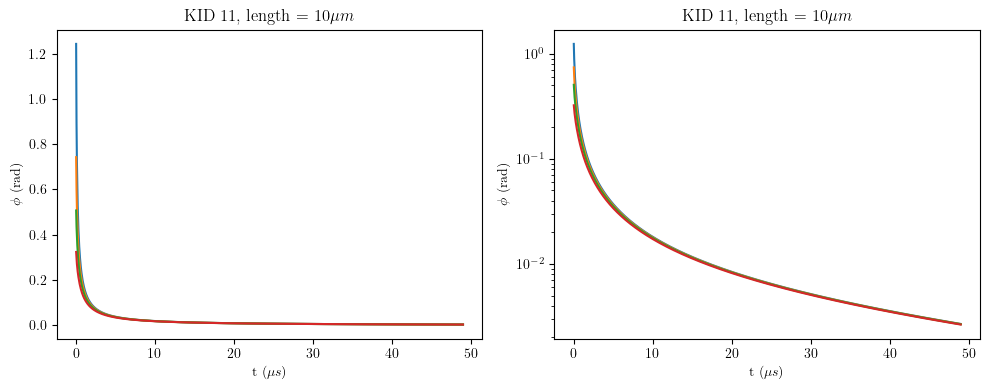

100%|██████████| 5000/5000 [00:06<00:00, 783.07it/s]


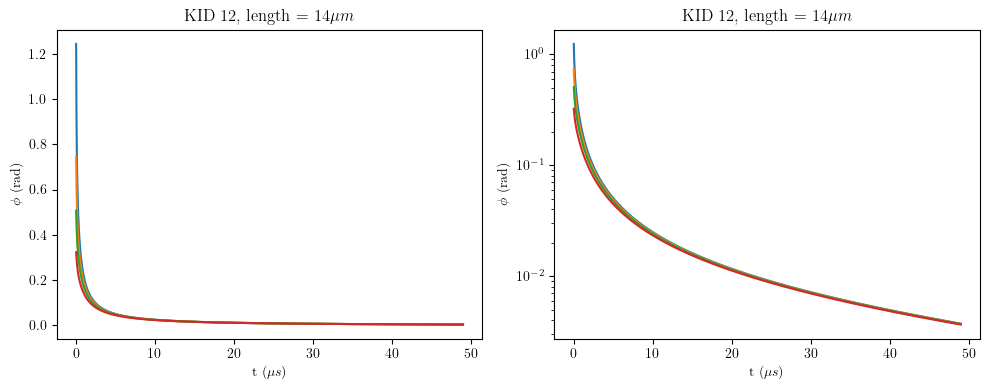

100%|██████████| 5000/5000 [00:06<00:00, 790.72it/s] 


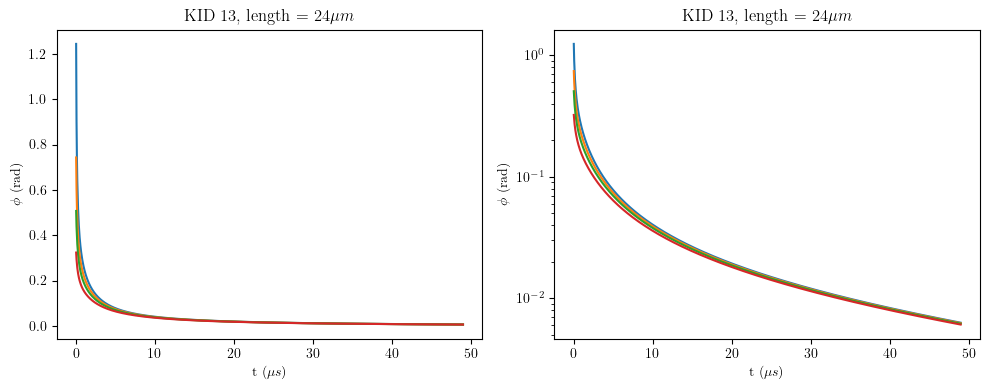

100%|██████████| 5000/5000 [00:08<00:00, 578.35it/s]


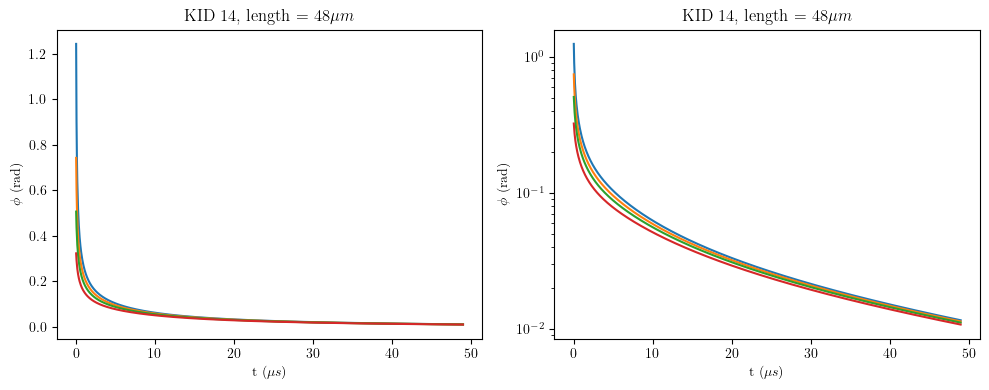

100%|██████████| 5000/5000 [00:29<00:00, 171.81it/s]


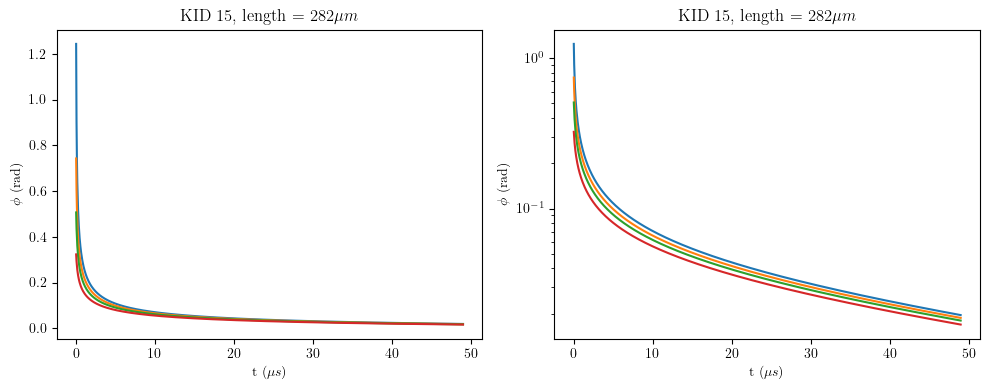

In [6]:
F0 = np.array([4.26,4.36,4.46,4.60,4.77,4.95,5.12,6.5,6.68,6.79,6.88,7.08,7.22])*1000
Q = np.array([58,62,59,63,61,59,62,19.7,19,21.9,19.3,20.2,20.9])
taus = Q/(np.pi*F0)
subV = np.array([1.44,2.4,3.36,5.76,8.64,17.3,223.2,1.44,2.4,3.36,5.76,11.52,67.68])
lengths = subV/(6*0.04)
number = np.array([1,2,3,4,5,6,7,10,11,12,13,14,15])

taxis = np.linspace(FITx[0],FITx[-1],1000)

for taur,length,no in zip(taus,lengths,number):
    for KIDno in KIDdict:
        KIDdict[KIDno].L = L
        KIDdict[KIDno].tau_ringing = taur
        KIDdict[KIDno].length = length
    plotfit = np.concatenate(Parallel(n_jobs=4)(delayed(func_to_parallelize)(taxis,50,500,l,KIDdict[l]) for l in KIDdict))
    plotfit = np.reshape(plotfit,np.stack([taxis,taxis,taxis,taxis]).shape)
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    for y,fit in zip(plotdatay,plotfit):
        plt.title('KID '+ str(no) + ', length = '+str(int(round(length)))+r'$\mu m$')
        plt.xlabel(r't ($\mu s$)')
        plt.ylabel(r'$\phi$ (rad)')
        plt.plot(taxis,fit)
    plt.subplot(1,2,2)
    for y,fit in zip(plotdatay,plotfit):
        plt.title('KID '+ str(no) + ', length = '+str(int(round(length)))+r'$\mu m$')
        plt.xlabel(r't ($\mu s$)')
        plt.ylabel(r'$\phi$ (rad)')
        plt.semilogy(taxis,fit)
    plt.tight_layout()      
    plt.savefig('plots K=50/KID' + str(no))  
    plt.show()